<a href="https://colab.research.google.com/github/Duannnnnnnnn/EfficientNet/blob/main/efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 12705.7754 - mae: 108.0352 - mse: 12703.4209 - val_loss: 11513.2207 - val_mae: 102.5462 - val_mse: 11510.8496 - learning_rate: 5.0000e-04
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 771ms/step - loss: 11891.1982 - mae: 104.3643 - mse: 11888.8125 - val_loss: 12322.9971 - val_mae: 107.7647 - val_mse: 12320.5576 - learning_rate: 5.0000e-04
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - loss: 10416.9658 - mae: 97.2230 - mse: 10414.4941 - val_loss: 9830.5439 - val_mae: 94.1833 - val_mse: 9827.9648 - learning_rate: 5.0000e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 8615.8018 - mae: 86.8221 - mse: 8613.1719 - val_loss: 9320.0186 - val_mae: 92.9821 - val_mse: 9317.2148 - learning_rate: 5.0000e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - loss: 6477.2197 - mae: 73.0437 - mse: 6474.3457 - val_loss: 6413.9185 - val_mae: 73.9953 - val_mse: 6410.8105 - learning_rate: 5.0000e-04
Epoch 6/50
11/11 ━━━━━━━━━━

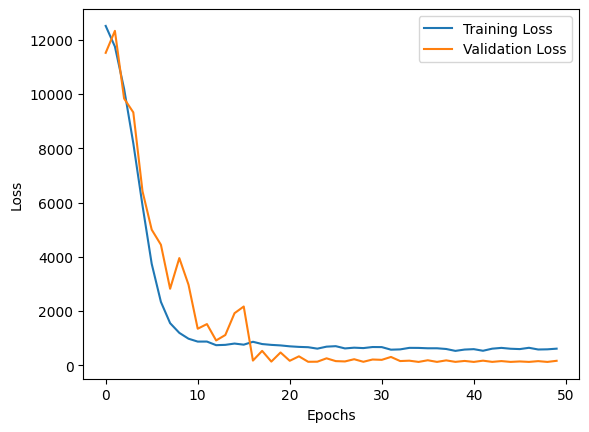

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

# Step 1: Setup Google Colab environment and install necessary libraries
# Make sure to select a GPU runtime in Google Colab for faster training

# Install TensorFlow and EfficientNet libraries
# !pip install tensorflow
# !pip install -q efficientnet

# Import the required packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 2: Data Preprocessing
# Load your dataset, which consists of images and the coordinates of four key points for the hip

# Assuming you have a folder named 'images' with images and an Excel file named 'labels.xlsx'
# 'labels.xlsx' contains columns: [image_name, x1, y1, x2, y2, x3, y3, x4, y4]

dataset_path = "/content/drive/MyDrive/xray_IHDI/"  # Change path to your dataset location
images_path = "/content/drive/MyDrive/xray_IHDI/images"
labels_folder_path = "/content/drive/MyDrive/xray_IHDI/annotations"

# Load CSV labels for each image
def load_labels(image_name):
    label_path = os.path.join(labels_folder_path, image_name.replace('.jpg', '.csv'))  # Assuming label filenames match image filenames
    labels_df = pd.read_csv(label_path, header=None)
    labels = labels_df.values.flatten()
    parsed_labels = []
    for label in labels:
        label = label.strip('()')
        x, y = map(float, label.split(','))
        parsed_labels.extend([x, y])
    return np.array(parsed_labels)



# Split the dataset into training and validation
# Get a list of all image filenames
image_filenames = os.listdir(images_path)

# Split the dataset into training and validation
train_filenames, val_filenames = train_test_split(image_filenames, test_size=0.1, random_state=42)

# Function to load and preprocess an image
def load_image(image_name, target_size=(224, 224)):
    image_path = os.path.join(images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_size = (image.shape[1], image.shape[0])
    image = cv2.resize(image, target_size) / 255.0
    image = np.stack([image] * 3, axis=-1)  # Normalize to [0, 1]
    return image, original_size


# Function to preprocess labels (keypoints)
def preprocess_labels(labels, original_size, target_size=(224, 224)):
    x_ratio = target_size[0] / original_size[0]
    y_ratio = target_size[1] / original_size[1]
    return labels.astype(float) * np.array([x_ratio, y_ratio] * (len(labels) // 2))


# Generator function to yield batches of data
# Generator function to yield batches of data
def data_generator(filenames, batch_size=8, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=0.5,
        width_shift_range=0.02,
        height_shift_range=0.02,
        zoom_range=0.03,
        brightness_range=(0.9, 1.1),
        shear_range=0.0,
        horizontal_flip=False,
        fill_mode='nearest'
    )
    while True:
        batch_images = []
        batch_labels = []
        for filename in filenames:
            image_name = filename
            labels = load_labels(image_name)

            # Load and preprocess image and labels
            image, original_size = load_image(image_name, target_size=target_size)
            image = datagen.random_transform(image)
            labels = preprocess_labels(labels, original_size)

            batch_images.append(image)
            batch_labels.append(labels)

            # Yield the batch when it reaches batch_size
            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images = []
                batch_labels = []
        if len(batch_images) > 0:
            yield np.array(batch_images), np.array(batch_labels)


# Step 3: Model Definition
# Load EfficientNetB0 model and modify the output for keypoint regression
base_model = efn.EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


# Create the regression model
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(global_avg_pool)
dropout = tf.keras.layers.Dropout(0.5)(dense_1)
output_layer = tf.keras.layers.Dense(16, activation='linear')(dropout)  # 8 key points * 2 coordinates each

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),

              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae', 'mse'])

# Step 4: Train the Model
# Define hyperparameters
batch_size = 8
epochs = 50
steps_per_epoch = max(1, len(train_filenames) // batch_size)
validation_steps = max(1, len(val_filenames) // batch_size)

# Create data generators
train_generator = data_generator(train_filenames, batch_size=batch_size)
val_generator = data_generator(val_filenames, batch_size=batch_size)

# Train the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(train_generator,
                    callbacks=[lr_scheduler],
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    epochs=epochs)

# Step 5: Fine-Tuning (Optional)
# Unfreeze some layers in the base model to fine-tune
for layer in base_model.layers[-10:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.Huber(delta=1.0),  # Smooth L1 loss
              metrics=['mae'])

# Continue training for a few more epochs
history_fine_tune = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              epochs=20)

# Step 6: Save the Model
model.save("hip_keypoint_model.keras")

# Step 7: Testing and Evaluation
# Write testing code here if you have a test dataset available

# Plot training history to see loss and metric trends
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Step 1: Setup Google Colab environment and install necessary libraries
# Make sure to select a GPU runtime in Google Colab for faster training

# Install TensorFlow and EfficientNet libraries
!pip install tensorflow
!pip install -q efficientnet

# Import the required packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Step 2: Data Preprocessing
# Load your dataset, which consists of images and the coordinates of four key points for the hip

# Assuming you have a folder named 'images' with images and an Excel file named 'labels.xlsx'
# 'labels.xlsx' contains columns: [image_name, x1, y1, x2, y2, x3, y3, x4, y4]

dataset_path = "/content/drive/MyDrive/xray_IHDI/"  # Change path to your dataset location
images_path = "/content/drive/MyDrive/xray_IHDI/images"
labels_folder_path = "/content/drive/MyDrive/xray_IHDI/annotations"

# Load CSV labels for each image
def load_labels(image_name):
    label_path = os.path.join(labels_folder_path, image_name.replace('.jpg', '.csv'))  # Assuming label filenames match image filenames
    labels_df = pd.read_csv(label_path, header=None)
    labels = labels_df.values.flatten()
    parsed_labels = []
    for label in labels:
        label = label.strip('()')
        x, y = map(float, label.split(','))
        parsed_labels.extend([x, y])
    return np.array(parsed_labels)



# Split the dataset into training and validation
# Get a list of all image filenames
image_filenames = os.listdir(images_path)

# Split the dataset into training and validation
train_filenames, val_filenames = train_test_split(image_filenames, test_size=0.1, random_state=42)

# Function to load and preprocess an image
def load_image(image_name, target_size=(224, 224)):
    image_path = os.path.join(images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    original_size = (image.shape[1], image.shape[0])
    image = cv2.resize(image, target_size) / 255.0
    image = np.stack([image] * 3, axis=-1)  # Normalize to [0, 1]
    return image, original_size


# Function to preprocess labels (keypoints)
def preprocess_labels(labels, original_size, target_size=(224, 224)):
    x_ratio = target_size[0] / original_size[0]
    y_ratio = target_size[1] / original_size[1]
    return labels.astype(float) * np.array([x_ratio, y_ratio] * (len(labels) // 2))


# Generator function to yield batches of data
# Generator function to yield batches of data
def data_generator(filenames, batch_size=8, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=3,
        width_shift_range=0.03,
        height_shift_range=0.0,
        zoom_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    ) # Reduced batch size for stability
    while True:
        batch_images = []
        batch_labels = []
        for filename in filenames:
            image_name = filename
            labels = load_labels(image_name)

            # Load and preprocess image and labels
            image, original_size = load_image(image_name, target_size=target_size)
            image = datagen.random_transform(image)
            # image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB for EfficientNet - This line is removed
            # as it is called previously in the load_image function and causes redundant stacking
            labels = preprocess_labels(labels, original_size)


            batch_images.append(image)
            batch_labels.append(labels)

            # Yield the batch when it reaches batch_size
            if len(batch_images) == batch_size:
                yield np.array(batch_images), np.array(batch_labels)
                batch_images = []
                batch_labels = []
        if len(batch_images) > 0:
            yield np.array(batch_images), np.array(batch_labels)


# Step 3: Model Definition
# Load EfficientNetB0 model and modify the output for keypoint regression
base_model = efn.EfficientNetB3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False


# Create the regression model
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
dense_1 = tf.keras.layers.Dense(224, activation='relu')(global_avg_pool)
dropout = tf.keras.layers.Dropout(0.5)(dense_1)
output_layer = tf.keras.layers.Dense(16, activation='linear')(dropout)  # 4 key points * 2 coordinates each

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae', 'mse'])

# Step 4: Train the Model
# Define hyperparameters
batch_size = 8
epochs = 50
steps_per_epoch = max(1, len(train_filenames) // batch_size)
validation_steps = max(1, len(val_filenames) // batch_size)

# Create data generators
train_generator = data_generator(train_filenames, batch_size=batch_size)
val_generator = data_generator(val_filenames, batch_size=batch_size)

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    epochs=epochs)

# Step 5: Fine-Tuning (Optional)
# Unfreeze some layers in the base model to fine-tune
for layer in base_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.Huber(delta=1.0),  # Smooth L1 loss
              metrics=['mae'])

# Continue training for a few more epochs
history_fine_tune = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              epochs=20)

# Step 6: Save the Model
model.save("hip_keypoint_model.keras")

# Step 7: Testing and Evaluation
# Write testing code here if you have a test dataset available

# Plot training history to see loss and metric trends
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
